In [1]:
#July 28
"""
Adding in a star-forming fraction to account for the difference of sf vs quiescent galaxies
"""

import ares
import numpy as np
import matplotlib.pyplot as pl

In [2]:
pop_halo = ares.populations.HaloPopulation()
data = ares.analysis.GalaxyPopulation() #for lit values

#### Quenched vs SF
For given mass, what is chance it is quenched?  
Parametrize # objects that are quenched wrt (mass, z)

This gives two different gals: SF >> Q  
	SF: Dn/dm * sf_fract  
	Q: Dn/dm * (1-sf_fract)   

Sf_fract ~ linear to mass for now (halo mass I guess?)


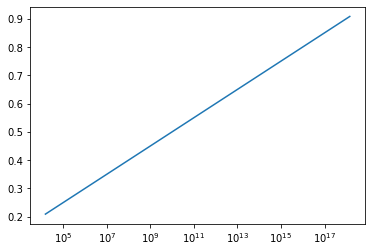

In [49]:
#it's a fraction so [0, 1] - how to make sure this happens? cause mass is going to be a big value
#also which way should it go?

sf_frac = lambda c, b, mass: c*mass + b

def fract(c, b):
    f = c*np.log10(pop_halo.halos.tab_M) + b
    #should it be logged?
    
    return f

pl.semilogx(pop_halo.halos.tab_M, fract(0.05, 0))
pl.show()

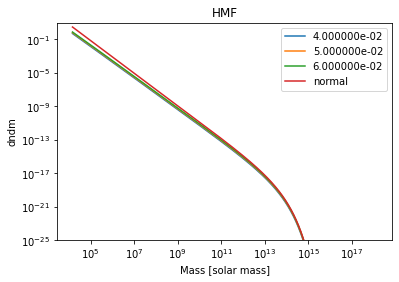

In [52]:
z = 2

# for c in [1e-18, 1e-19, 1e-20]:
for c in [0.04, 0.05, 0.06]:

    i = np.argmin(np.abs(z - pop_halo.halos.tab_z))
    pl.loglog(pop_halo.halos.tab_M, pop_halo.halos.tab_dndm[i, :]*fract(c, 0), label='%e' %c)
    
pl.loglog(pop_halo.halos.tab_M, pop_halo.halos.tab_dndm[i, :], label='normal')
pl.legend()
pl.ylabel('dndm')
pl.xlabel('Mass [solar mass]')
pl.title('HMF')

pl.ylim(1e-25, 10)
pl.show()

In [3]:
# derivative of m(M) wrt M
def dm_dM(pop_halo, N, M_1, beta, gamma, mM_ratio):
    n2 = (-beta)*(pop_halo.halos.tab_M**(-beta-1)/M_1**(-beta)) + gamma*(pop_halo.halos.tab_M**(gamma-1)/M_1**(gamma))
    
    dydx = mM_ratio - pop_halo.halos.tab_M * 2 * N * n2 * ( (pop_halo.halos.tab_M/M_1)**(-beta) + \
                                                            (pop_halo.halos.tab_M/M_1)**(gamma) )**(-2) 

    return dydx

#derivative of log10( m ) wrt M
def dlogm_dM(pop_halo, N, M_1, beta, gamma, mM_ratio):
    
    dydx = -1* ((gamma-1)*(pop_halo.halos.tab_M/M_1)**(gamma+beta) - beta - 1) / (np.log(10)*pop_halo.halos.tab_M*((pop_halo.halos.tab_M/M_1)**(gamma+beta) + 1))

    return dydx

In [53]:
#double power law
c = 0.05
b = 0

def SMF_Moster2010(z, pop_halo, N, M_1, beta, gamma, sf=True):
    
    k = np.argmin(np.abs(z - pop_halo.halos.tab_z))
    
    mM_ratio = np.log10( 2*N / ( (pop_halo.halos.tab_M/M_1)**(-beta) + (pop_halo.halos.tab_M/M_1)**(gamma) ) )#equ 2
    
    """
    tab_dndm (halo) -> dndlog(m) (SM)
    need: tab_dndm / d(log(ratio)/dM
    """
    
    if sf: #star-forming 
        SMF = pop_halo.halos.tab_dndm[k, :]*fract(c, b) / dlogm_dM(pop_halo, N, M_1, beta, gamma, mM_ratio) #dn/dM / d(log10(m))/dM
    else: # quiescent
        SMF = pop_halo.halos.tab_dndm[k, :]*(1-fract(c, b)) / dlogm_dM(pop_halo, N, M_1, beta, gamma, mM_ratio) #dn/dM / d(log10(m))/dM

    
    return SMF,  mM_ratio

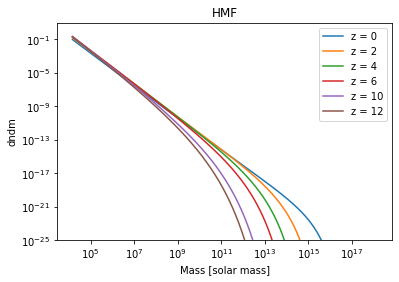

In [37]:
#checking HMF form
for z in [0, 2, 4, 6, 10, 12]:
    i = np.argmin(np.abs(z - pop_halo.halos.tab_z))
    pl.loglog(pop_halo.halos.tab_M, pop_halo.halos.tab_dndm[i, :]*0.05, label='z = %i' %z)
    
pl.legend()
pl.ylabel('dndm')
pl.xlabel('Mass [solar mass]')
pl.title('HMF')

pl.ylim(1e-25, 10)
pl.show()

Seperating the double power law so the behavior of each exponent can be seen.

In [8]:
#only beta - low mass behavior
def SMF_b(z, pop_halo, N, M_1, beta):
    
    k = np.argmin(np.abs(z - pop_halo.halos.tab_z))
    
    mM_ratio = np.log10(2*N / ( (pop_halo.halos.tab_M/M_1)**(-beta)) ) #equ 2
    
    SMF = pop_halo.halos.tab_dndm[k, :] / dlogm_dM(pop_halo, N, M_1, beta, gamma, mM_ratio) #HMF * m/M

    return SMF,  mM_ratio

#only gamma - high mass behavior
def SMF_g(z, pop_halo, N, M_1, gamma):
    
    k = np.argmin(np.abs(z - pop_halo.halos.tab_z))
    
    mM_ratio = np.log10(2*N / ((pop_halo.halos.tab_M/M_1)**(gamma) ) )#equ 2
    
    SMF = pop_halo.halos.tab_dndm[k, :] / dlogm_dM(pop_halo, N, M_1, beta, gamma, mM_ratio) #HMF * m/M

    return SMF,  mM_ratio

### Higher redshift
With redshift-dependent parameterizations

$logM_1 = logM_0 \cdot (z + 1)^\mu$  
$N_1 = N_0 \cdot (z + 1)^\nu$  
$\gamma = \gamma_0 \cdot (z + 1)^{\gamma_1}$  
$\beta = \beta_1 \cdot z + \beta_0 $ 

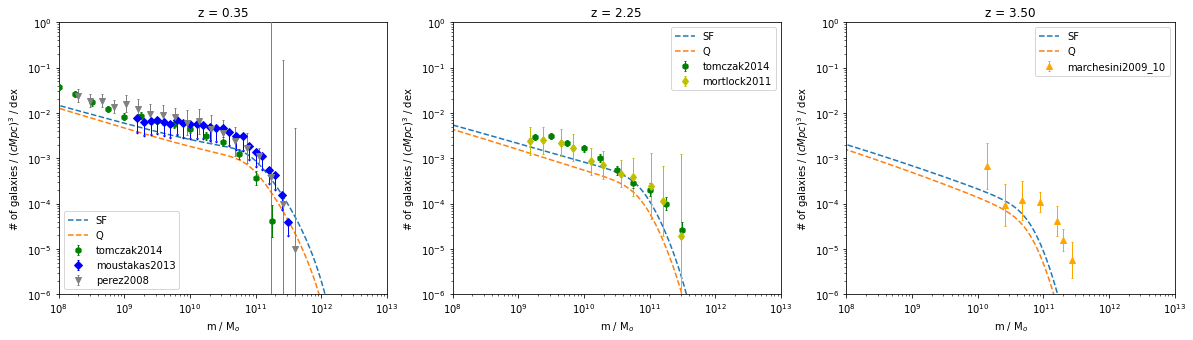

In [56]:
fig, axs = pl.subplots(1, 3, figsize=(20, 5))

#From Moster2010, table 7
logM_0 = 11.88 #(0.01)
mu = 0.019 #(0.002)
N_0 = 0.0282 #(0.0003)
nu = -0.72 #(0.06)
gamma_0 = 0.556 #0.001
gamma_1 = -0.26 #(0.05)
beta_0 = 1.06 #(0.06)
beta_1 = 0.17 #(0.12)

for i, z in enumerate([0.35, 2.25, 3.5]):
    #Redshift-dependent parameterizations
    N = N_0 * (z + 1)**nu
    M_1 = 10**(logM_0*(z+1)**mu)
    beta = beta_1*z+beta_0
    gamma = gamma_0*(z + 1)**gamma_1
       
    #plot lit values
    data.PlotSMF(z=z, round_z=0.2, ax=axs[i])
    
    SMF_sf, r = SMF_Moster2010(z, pop_halo, N, M_1, beta, gamma)
    SMF_q, r = SMF_Moster2010(z, pop_halo, N, M_1, beta, gamma, sf=False)

    #using equ 2 to get the new stellar masses
    Sm = 10**(r + np.log10(pop_halo.halos.tab_M))

    #plotting
    axs[i].loglog(Sm, SMF_sf, label='SF', ls="--")
    axs[i].loglog(Sm, SMF_q, label='Q', ls="--")

    
    axs[i].set_title("z = %.2f" %z)
    axs[i].set(xlabel='m / M$_o$', ylabel='# of galaxies / $ (cMpc)^3$ / dex')
    axs[i].set_ylim(1e-6, 1e0)
    axs[i].set_xlim(1e8, )
#     axs[i].axvline(10**(8.7), color="purple", label="Their lower limit-ish", ls=":")
    axs[i].legend()

pl.show()